In [1]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from matplotlib.pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import linear_model
rcParams['figure.figsize'] = 15, 6
plt.rcParams['agg.path.chunksize'] = 10000

### datacleaning:
- we first load the dataset

In [2]:
data = pd.read_csv('la-haute-borne-data-2017-2020.csv',sep=';')

In [3]:
data.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80721,2017-02-08T08:00:00+01:00,44.990002,44.990002,44.990002,0.0,14.0,14.0,14.0,0.0,...,NaN,NaN,358.04999,NaN,NaN,NaN,358.04999,NaN,NaN,NaN
1,R80721,2017-01-26T02:40:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R80721,2017-01-26T13:50:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R80721,2017-01-26T15:00:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R80721,2017-02-18T01:10:00+01:00,44.990002,44.990002,44.990002,0.0,17.0,17.0,17.0,0.0,...,NaN,NaN,7.99000,NaN,NaN,NaN,7.99000,NaN,NaN,NaN


- then we remove all empty columns

In [4]:
data = data.drop('Va1_avg', 1)
data = data.drop('Va2_avg', 1)
data = data.drop('Pas_avg', 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [5]:
data["P_avg"].head()

0     -1.89000
1    197.32001
2    176.45000
3    190.61000
4     -2.88000
Name: P_avg, dtype: float64

- then we clip our windpower, so we do not have negative power

In [6]:
data["P_avg"] = data["P_avg"].clip(lower=0)

In [7]:
data["P_avg"].head()

0      0.00000
1    197.32001
2    176.45000
3    190.61000
4      0.00000
Name: P_avg, dtype: float64

- we have to convert our timestamp to a usefull format

In [8]:
data['Date_time'] = pd.to_datetime(data['Date_time'], utc=True)

data["date"] = pd.to_datetime(data['Date_time']).apply(lambda x: x.date())
data['monthdate'] = pd.DatetimeIndex(data['Date_time']).month
data['year'] = data['Date_time'].dt.year
data['month'] = data['Date_time'].dt.month
data['day'] = data['Date_time'].dt.day
data['year'] = data["year"].values
data['month'] = data["month"].values
data['day'] = data["day"].values

In [9]:
print("days: ",data['day'].head()) 
print("")
print("months: ",data['month'].head()) 
print("")
print("years :",data['year'].head())

days:  0     8
1    26
2    26
3    26
4    18
Name: day, dtype: int64

months:  0    2
1    1
2    1
3    1
4    2
Name: month, dtype: int64

years : 0    2017
1    2017
2    2017
3    2017
4    2017
Name: year, dtype: int64




- first we drop NaNs and delete outliers

In [10]:
selected_columns = data[["Date_time","P_avg","day","Ba_avg","Rt_avg","Yt_avg","Ws_avg","Ot_avg"]]
df = selected_columns.copy()
df.dropna(axis = 0, how ='any', inplace=True)
df = df[df['P_avg'].notna()]
df = df[df['Ba_avg'].notna()]
df = df[df['Rt_avg'].notna()]
df = df[df['Yt_avg'].notna()]
df = df[df['Ws_avg'].notna()]
df = df[df['Ot_avg'].notna()]

In [11]:
Ws = df.sort_values(by=["Ws_avg"], ascending=False) # Wind speed
Ot = df.sort_values(by=["Ot_avg"], ascending=False) # temperature
Yt = df.sort_values(by=["Yt_avg"], ascending=False) # nacelle temperature
Rt = df.sort_values(by=["Rt_avg"], ascending=False) # hub temperature
Ba = df.sort_values(by=["Ba_avg"], ascending=False) # pitch angle

- we look at every column to see whether there appear some untypical numbers or not.

In [12]:
Ws.head() 

,Date_time,P_avg,day,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
212826,2018-01-03 07:20:00+00:00,284.88,3,78.71,18.32,16.30,24.27,8.12
210705,2018-01-03 07:20:00+00:00,545.07,3,66.90,17.92,16.36,23.48,7.76
177441,2018-01-03 07:20:00+00:00,1296.88,3,44.33,19.00,16.07,23.00,7.77
212232,2018-01-03 04:30:00+00:00,2048.26,3,19.92,18.00,19.32,21.67,12.54
173248,2018-01-03 05:20:00+00:00,1436.69,3,38.10,18.77,18.46,21.30,11.39


--> no outliers in Windspeed

In [13]:
Ot.head()

,Date_time,P_avg,day,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
74205,2017-02-03 13:50:00+00:00,4.3,3,75.300003,15.46,39.560001,7.90,70.980003
15679,2017-02-03 13:40:00+00:00,0.0,3,91.699997,15.16,56.090000,6.08,68.699997
108390,2017-06-21 12:00:00+00:00,0.0,21,45.000000,36.00,41.630000,2.70,35.870000
108384,2017-06-21 11:30:00+00:00,0.0,21,45.000000,35.00,40.530000,0.88,35.860000
100836,2017-06-21 12:00:00+00:00,0.0,21,43.910000,35.00,40.530000,1.07,35.700000


--> two significant outliers which we will set to the more natural max of 35

In [14]:
df["Ot_avg"] = df["Ot_avg"].clip(upper=36)

In [15]:
clippedOt = df.sort_values(by=["Ot_avg"], ascending=False) # temperature
clippedOt.head()

,Date_time,P_avg,day,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
15679,2017-02-03 13:40:00+00:00,0.0,3,91.699997,15.16,56.090000,6.08,36.00
74205,2017-02-03 13:50:00+00:00,4.3,3,75.300003,15.46,39.560001,7.90,36.00
108390,2017-06-21 12:00:00+00:00,0.0,21,45.000000,36.00,41.630000,2.70,35.87
108384,2017-06-21 11:30:00+00:00,0.0,21,45.000000,35.00,40.530000,0.88,35.86
100836,2017-06-21 12:00:00+00:00,0.0,21,43.910000,35.00,40.530000,1.07,35.70


In [16]:
Yt.head()

,Date_time,P_avg,day,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
15679,2017-02-03 13:40:00+00:00,0.00,3,91.699997,15.16,56.09,6.08,68.699997
48060,2017-07-06 14:40:00+00:00,52.92,6,-0.710000,34.49,42.79,4.42,32.350000
129799,2017-07-08 07:20:00+00:00,0.00,8,45.000000,32.00,42.79,2.55,30.180000
158329,2017-06-21 13:50:00+00:00,74.15,21,-0.410000,36.00,42.70,4.76,34.370000
205953,2017-08-29 10:20:00+00:00,18.50,29,0.680000,32.96,42.69,4.12,32.460000


In [17]:
Rt.head()

,Date_time,P_avg,day,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
163009,2017-09-07 11:50:00+00:00,0.0,7,91.68,215.00,27.59,4.14,18.22
138342,2017-09-07 12:10:00+00:00,0.0,7,91.68,215.00,27.22,3.86,18.09
40783,2017-09-07 12:00:00+00:00,0.0,7,91.68,215.00,26.87,3.04,18.31
114277,2017-09-07 11:40:00+00:00,0.0,7,91.68,208.00,29.26,4.43,18.12
65624,2017-09-07 12:20:00+00:00,0.0,7,89.05,206.54,27.26,3.36,18.21


In [18]:
Ba.head()

,Date_time,P_avg,day,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
196885,2017-05-31 08:20:00+00:00,0.0,31,132.48,24.98,36.71,2.12,23.63
175114,2017-05-31 06:40:00+00:00,0.0,31,116.29,24.77,29.03,1.28,21.98
199986,2017-09-07 06:50:00+00:00,0.0,7,114.93,22.55,24.47,2.68,14.69
1315,2017-05-30 06:50:00+00:00,0.0,30,111.78,28.00,30.00,6.17,22.00
200879,2017-09-07 08:30:00+00:00,0.0,7,111.43,21.77,27.83,3.58,16.54


--> No more outliers in Yt, Rt and Ba

Now we can split our data into test and training data for our Support Vector Regression Model

In [19]:
# splitting the data
df = df.sort_values(by="Date_time")

x = df[["Ba_avg","day","Rt_avg","Yt_avg","Ws_avg","Ot_avg"]]
y = df['P_avg']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42) #80-20 split


We try different parameters:
- Gamma defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.
- epsilon specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value
- C is the Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty  
Large Value of parameter C => small margin  
Small Value of paramerter C => Large margin

In [61]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel="rbf", gamma='scale', C=1.0, epsilon=0.1) # 1/(n_features * X.var()) as value of gamma, C = 1,0, epsilon = 0.1
svr_rbf2 = SVR(kernel="rbf", gamma='scale', C=10.0, epsilon=1) # 1/(n_features * X.var()) as value of gamma, C = 10, epsilon = 1
svr_rbf3 = SVR(kernel="rbf", gamma="auto", C=1.0, epsilon=0.1) # uses 1 / n_features, C = 1, epsilon = 0.1
svr_rbf4 = SVR(kernel="rbf", gamma='scale', C=25.0, epsilon=5) # 1/(n_features * X.var()) as value of gamma, C = 25, epsilon = 5
svr_rbf5 = SVR(kernel="rbf", gamma='scale', C=50.0, epsilon=5) # 1/(n_features * X.var()) as value of gamma, C = 50, epsilon = 5
svr_rbf6 = SVR(kernel="rbf", gamma='scale', C=100.0, epsilon=20) # 1/(n_features * X.var()) as value of gamma, C = 100, epsilon = 20
svr_rbf7 = SVR(kernel="rbf", gamma='scale', C=150.0, epsilon=25) # 1/(n_features * X.var()) as value of gamma, C = 150, epsilon = 25


In [21]:
rbf_model = svr_rbf.fit(x_train,y_train)

In [22]:
rbf_model2 = svr_rbf2.fit(x_train,y_train)

In [23]:
rbf_model3 = svr_rbf3.fit(x_train,y_train)

In [36]:
rbf_model4 = svr_rbf4.fit(x_train,y_train)

In [37]:
rbf_model5 = svr_rbf5.fit(x_train,y_train)

In [39]:
rbf_model6 = svr_rbf6.fit(x_train,y_train)

In [62]:
rbf_model7 = svr_rbf7.fit(x_train,y_train)

In [24]:
rbf_predict = rbf_model.predict(x_test.values)

X does not have valid feature names, but SVR was fitted with feature names


In [25]:
rbf_predict2 = rbf_model2.predict(x_test.values)

X does not have valid feature names, but SVR was fitted with feature names


In [26]:
rbf_predict3 = rbf_model3.predict(x_test.values)

X does not have valid feature names, but SVR was fitted with feature names


In [40]:
rbf_predict4 = rbf_model4.predict(x_test.values)

X does not have valid feature names, but SVR was fitted with feature names


In [41]:
rbf_predict5 = rbf_model5.predict(x_test.values)

X does not have valid feature names, but SVR was fitted with feature names


In [42]:
rbf_predict6 = rbf_model6.predict(x_test.values)

X does not have valid feature names, but SVR was fitted with feature names


In [63]:
rbf_predict7 = rbf_model7.predict(x_test.values)

X does not have valid feature names, but SVR was fitted with feature names


RBF model evaluation:

In [27]:
# Model 1 
# 1/(n_features * X.var()) as value of gamma, C = 1,0, epsilon = 0.1

y_pred = abs(rbf_predict) 
print("MAE: {}".format(np.abs(y_test-rbf_predict).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-rbf_predict)**2).mean())))
from sklearn.metrics import r2_score
r2 = r2_score(y_test.values, rbf_predict)
print("r2: {}".format(r2))

MAE: 77.70472583432307
RMSE: 125.48614240836373
r2: 0.924832446749225


In [28]:
# Model 2
# 1/(n_features * X.var()) as value of gamma, C = 10, epsilon = 1

y_pred = abs(rbf_predict2) 
print("MAE: {}".format(np.abs(y_test-rbf_predict2).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-rbf_predict2)**2).mean())))
from sklearn.metrics import r2_score
r2 = r2_score(y_test.values, rbf_predict2)
print("r2: {}".format(r2))

MAE: 49.737600270568606
RMSE: 81.99620019153276
r2: 0.9679058165621246


In [29]:
# Model 3
# uses 1 / n_features, C = 1, epsilon = 0.1

y_pred = abs(rbf_predict3) 
print("MAE: {}".format(np.abs(y_test-rbf_predict3).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-rbf_predict3)**2).mean())))
from sklearn.metrics import r2_score
r2 = r2_score(y_test.values, rbf_predict3)
print("r2: {}".format(r2))

MAE: 233.40052076620947
RMSE: 433.52284186951545
r2: 0.10285457611170656


In [43]:
# Model 4
# 1/(n_features * X.var()) as value of gamma, C = 25, epsilon = 5

y_pred = abs(rbf_predict4) 
print("MAE: {}".format(np.abs(y_test-rbf_predict4).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-rbf_predict4)**2).mean())))
from sklearn.metrics import r2_score
r2 = r2_score(y_test.values, rbf_predict4)
print("r2: {}".format(r2))

MAE: 45.927041586239795
RMSE: 74.60693865490866
r2: 0.973429647488268


In [44]:
# Model 5
# 1/(n_features * X.var()) as value of gamma, C = 50, epsilon = 5

y_pred = abs(rbf_predict5) 
print("MAE: {}".format(np.abs(y_test-rbf_predict5).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-rbf_predict5)**2).mean())))
from sklearn.metrics import r2_score
r2 = r2_score(y_test.values, rbf_predict5)
print("r2: {}".format(r2))

MAE: 42.75926862672341
RMSE: 68.8083508670512
r2: 0.9773993372472995


In [45]:
# Model 6
# 1/(n_features * X.var()) as value of gamma, C = 100, epsilon = 15

y_pred = abs(rbf_predict6) 
print("MAE: {}".format(np.abs(y_test-rbf_predict6).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-rbf_predict6)**2).mean())))
from sklearn.metrics import r2_score
r2 = r2_score(y_test.values, rbf_predict6)
print("r2: {}".format(r2))

MAE: 41.188283953966874
RMSE: 64.0141658095327
r2: 0.9804389998138299


In [64]:
# Model 7
# 1/(n_features * X.var()) as value of gamma, C = 150, epsilon = 25

y_pred = abs(rbf_predict7) 
print("MAE: {}".format(np.abs(y_test-rbf_predict7).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-rbf_predict7)**2).mean())))
from sklearn.metrics import r2_score
r2 = r2_score(y_test.values, rbf_predict7)
print("r2: {}".format(r2))

MAE: 40.3454395123244
RMSE: 62.02481452389692
r2: 0.981635892563855


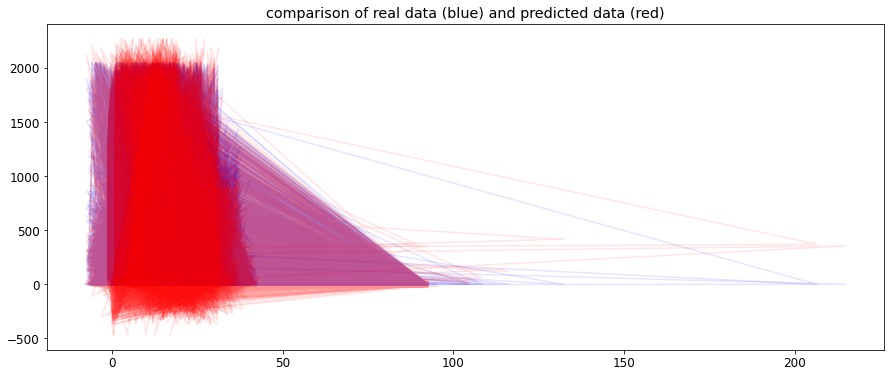

In [65]:
plt.plot(x_test.values, y_test.values, color = 'blue', alpha=0.1)
plt.plot(x_test.values, rbf_predict7, color = 'red', alpha=0.1)
plt.title('comparison of real data (blue) and predicted data (red)')
plt.show()

In [66]:
sort = data.sort_values(by=["Date_time"], inplace=False)
time = sort["Date_time"]
lasttwentyPecent = time.iloc[int(-43128):]

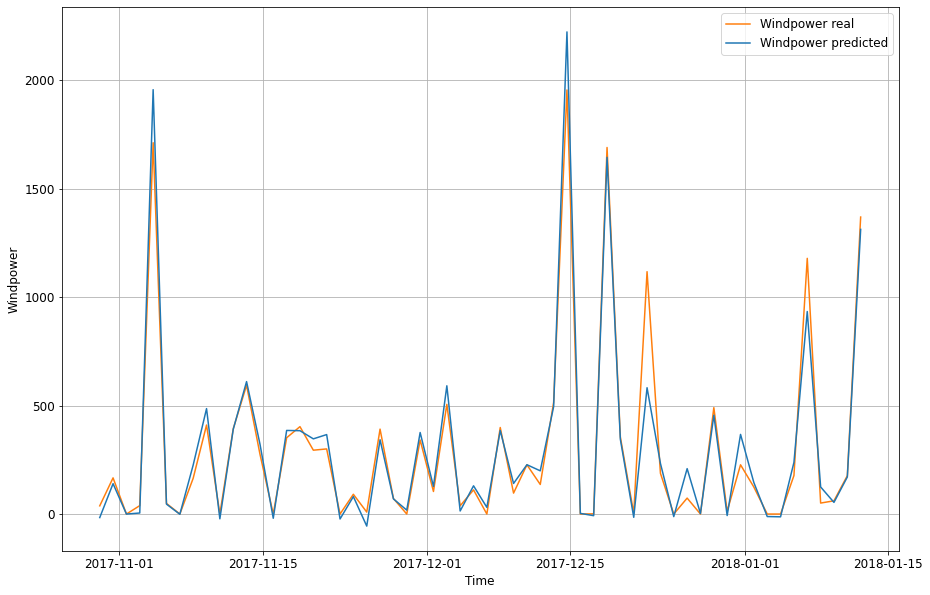

In [67]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

x1 = lasttwentyPecent[::750]
y1 = y_test[::750]
y2 = rbf_predict7[::750]

ax.plot(x1, y1, color='tab:orange', label='Windpower real')
ax.plot(x1, y2, color='tab:blue', label='Windpower predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Windpower')
ax.set_title('')
ax.grid(True)
ax.legend(loc='upper right');

In [33]:
# compute the SHAP values for the linear model
# explainer = shap.KernelExplainer(rbf_model.predict, x_test)
# shap_values = explainer.shap_values(x_test)
# shap.summary_plot(shap_values, x, plot_type="bar")

In [58]:
dpred = rbf_predict6.reshape(-1,1)

In [59]:
import hydrostats.ens_metrics as em
crps_dictionary_rand = em.crps_kernel(y_test, dpred)
print(crps_dictionary_rand['crps'])

KeyError: 0

In [60]:
aa

NameError: name 'aa' is not defined

In [ ]:
# compute the SHAP values for the linear model
explainerSampling = shap.explainers.Sampling(rbf_model.predict, x_test)
shap_valuesES = explainerSampling.shap_values(x_test)
shap.summary_plot(shap_valuesES, x, plot_type="bar")

In [ ]:
# compute the SHAP values for the linear model
explainer = shap.LinearExplainer(rbf_model.predict, x_test) 
shap_values = explainer(x_test) 
shap.plots.beeswarm(shap_values)

In [ ]:
# compute the SHAP values for the linear model
explainer = shap.LinearExplainer(modelLR, x_test) 
shap_values = explainer(x_test)
shap.plots.scatter(shap_values)